In [1]:
import sys
sys.path.append('../')
import numpy as np
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import softmax
from scipy import spatial
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from framework.mtl_model import MTLModel
from data.heads.pixel2pixel import ASPPHeadNode

In [2]:
headsDict = nn.ModuleDict()
tasks = ['segment_semantic', 'depth_zbuffer']  # Cityscapes
task_cls_num = {'segment_semantic': 19, 'depth_zbuffer': 1}  # Cityscapes

# tasks = ['segment_semantic','normal','depth_zbuffer'] # NYUv2
# task_cls_num = {'segment_semantic': 40, 'normal':3, 'depth_zbuffer': 1} # NYUv2

# tasks = ['segment_semantic', 'normal', 'depth_zbuffer', 'keypoints2d', 'edge_texture'] # Taskonomy 
# task_cls_num = {'segment_semantic': 17, 'normal': 3, 'depth_zbuffer': 1, 'keypoints2d': 1, 'edge_texture': 1} # Taskonomy

for task in tasks:
    headsDict[task] = ASPPHeadNode(512, task_cls_num[task]) # resnet34:512, mobiltnet:1280, mnasnet:1280

In [3]:
prototxt = '../models/deeplab_resnet34_adashare.prototxt'
# prototxt = 'models/mobilenetv2.prototxt'
# prototxt = 'models/mnasnet.prototxt'
mtlmodel = MTLModel(prototxt, headsDict, BNsp=True)
mtlmodel = mtlmodel.cuda()

# Policy Visualization

In [11]:
folder = '/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/'
# state = torch.load(folder+'Cityscapes/' + 'alter_train_with_reg_0005_20000iter.model')  # Cityscapes
# state = torch.load(folder+'NYUv2/' + 'alter_train_with_reg_001_20000iter.model')  # NYUv2
state = torch.load(folder+'Taskonomy/' + 'alter_train_with_reg_0005_20000iter.model')  # Taskonomy
mtlmodel.load_state_dict(state['state_dict'], strict=False)

<All keys matched successfully>

In [15]:
# policy_list = {'segment_semantic': [], 'depth_zbuffer': []}   # Cityscapes
# policy_list = {'segment_semantic': [], 'normal':[], 'depth_zbuffer': []}   # NYUv2
policy_list = {'segment_semantic': [], 'normal': [], 'depth_zbuffer': [], 'keypoints2d': [], 'edge_texture': []} # Taskonomy

for name, param in mtlmodel.named_parameters():
    if 'policy' in name and not torch.eq(param, torch.tensor([0., 0., 0.]).cuda()).all():
        policy = param.data.cpu().detach().numpy()
        distribution = softmax(policy, axis=-1)
        if 'segment_semantic' in name:
            policy_list['segment_semantic'].append(distribution)
        elif 'normal' in name:
            policy_list['normal'].append(distribution)
        elif 'depth_zbuffer' in name:
            policy_list['depth_zbuffer'].append(distribution)
        elif 'keypoints2d' in name:
            policy_list['keypoints2d'].append(distribution)
        elif 'edge_texture' in name:
            policy_list['edge_texture'].append(distribution)

In [14]:
policy_list

{'segment_semantic': [array([0.39202362, 0.35769948, 0.25027686], dtype=float32),
  array([0.46032843, 0.4008471 , 0.13882454], dtype=float32),
  array([0.4602718 , 0.3439025 , 0.19582564], dtype=float32),
  array([0.43130836, 0.33673358, 0.23195805], dtype=float32),
  array([0.37796295, 0.30625042, 0.31578678], dtype=float32),
  array([0.41446456, 0.3253184 , 0.26021713], dtype=float32),
  array([0.39369014, 0.32296875, 0.2833411 ], dtype=float32),
  array([0.40811697, 0.33306327, 0.2588198 ], dtype=float32),
  array([0.45477405, 0.34459704, 0.20062885], dtype=float32),
  array([0.46037307, 0.3331801 , 0.2064469 ], dtype=float32),
  array([0.43672514, 0.32076472, 0.24251011], dtype=float32),
  array([0.40801865, 0.32814568, 0.26383567], dtype=float32),
  array([0.38867933, 0.31296897, 0.29835165], dtype=float32),
  array([0.41328984, 0.3479279 , 0.23878224], dtype=float32),
  array([0.38451114, 0.3289499 , 0.28653893], dtype=float32),
  array([0.376637  , 0.315034  , 0.30832896], dtyp

/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


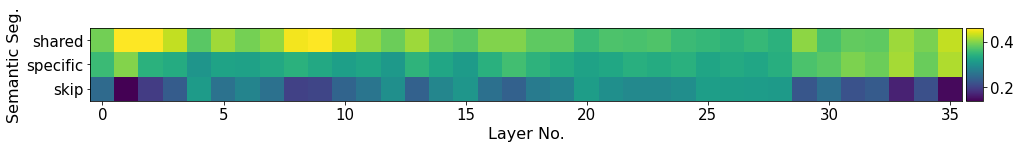

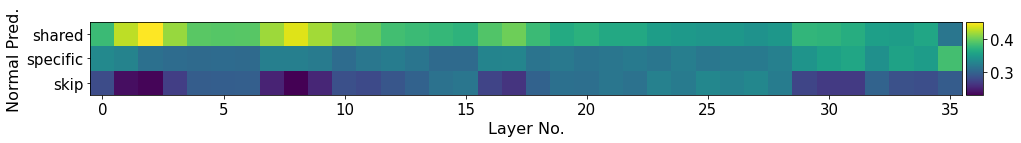

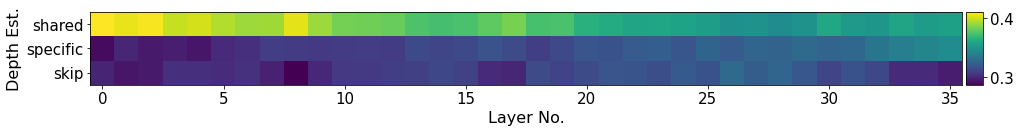

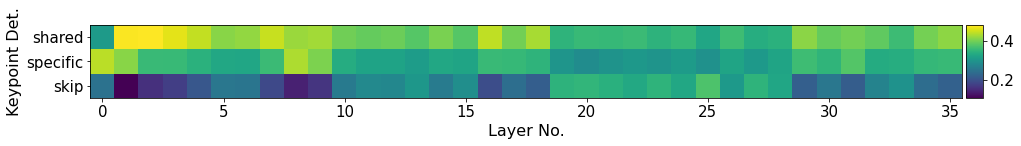

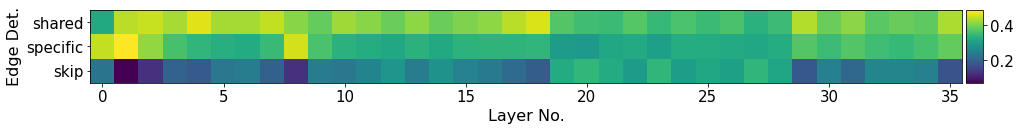

In [16]:
spectrum_list = []
# ylabels = {'segment_semantic': 'Semantic Seg.','depth_zbuffer': 'Depth Est.'} # Cityscapes
# ylabels = {'segment_semantic': 'Semantic Seg.','normal':'Normal Pred.', 'depth_zbuffer': 'Depth Est.'} # NYUv2
ylabels = {'segment_semantic': 'Semantic Seg.','normal':'Normal Pred.', 'depth_zbuffer': 'Depth Est.',
           'keypoints2d': 'Keypoint Det.', 'edge_texture': 'Edge Det.'} # Taskonomy


tickSize = 15
labelSize = 16
for task in tasks:
    policies = policy_list[task]    
    spectrum = np.stack([policy for policy in policies])
    
    spectrum = np.repeat(spectrum[np.newaxis,:,:],1,axis=0)
    spectrum_list.append(spectrum)
    
    # plot
    plt.figure(figsize=(16,2))
    plt.xlabel('Layer No.', fontsize=labelSize)
    plt.xticks(fontsize=tickSize)
    plt.ylabel(ylabels[task], fontsize=labelSize)
    plt.yticks(fontsize=tickSize)
    
    ax = plt.subplot()
    im = ax.imshow(spectrum.T)
    ax.set_yticks(np.arange(3))
    ax.set_yticklabels(['shared', 'specific', 'skip'])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)

    cb = plt.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=tickSize)
    plt.show()


# Task Correlation

In [49]:
folder = '/mnt/nfs/work1/huiguan/lijunzhang/policymtl/checkpoint/'
# state = torch.load(folder+'Taskonomy/sample_design3_0005_20000/0-40/' + 'post_train_best.model')  
state = torch.load(folder+'Taskonomy/' + 'alter_train_with_reg_0005_20000iter.model')  # Taskonomy
mtlmodel.load_state_dict(state['state_dict'], strict=False)

<All keys matched successfully>

In [50]:
policy_list = {'segment_semantic': [], 'normal': [], 'depth_zbuffer': [], 'keypoints2d': [], 'edge_texture': []} # Taskonomy
for name, param in mtlmodel.named_parameters():
    if 'policy' in name and not torch.eq(param, torch.tensor([0., 0., 0.]).cuda()).all():
        policy = param.data.cpu().detach().numpy()
        if 'segment_semantic' in name:
            policy_list['segment_semantic'].append(policy)
        elif 'normal' in name:
            policy_list['normal'].append(policy)
        elif 'depth_zbuffer' in name:
            policy_list['depth_zbuffer'].append(policy)
        elif 'keypoints2d' in name:
            policy_list['keypoints2d'].append(policy)
        elif 'edge_texture' in name:
            policy_list['edge_texture'].append(policy)

In [51]:
policy_array = np.array([np.array(policy_list['segment_semantic']).ravel(), 
                         np.array(policy_list['normal']).ravel(), 
                         np.array(policy_list['depth_zbuffer']).ravel(),
                         np.array(policy_list['keypoints2d']).ravel(),
                         np.array(policy_list['edge_texture']).ravel()])

In [53]:
sim = np.zeros((5,5))
for i in range(len(tasks)):
    for j in range(len(tasks)):
        sim[i,j] = 1 - spatial.distance.cosine(policy_array[i,:], policy_array[j,:])

In [54]:
sim

array([[1.        , 0.86430103, 0.71090776, 0.84819722, 0.87713093],
       [0.86430103, 1.        , 0.87953949, 0.85802144, 0.82584214],
       [0.71090776, 0.87953949, 1.        , 0.62769282, 0.60842031],
       [0.84819722, 0.85802144, 0.62769282, 1.        , 0.95255029],
       [0.87713093, 0.82584214, 0.60842031, 0.95255029, 1.        ]])

/home/lijunzhang/anaconda3/envs/multitask/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


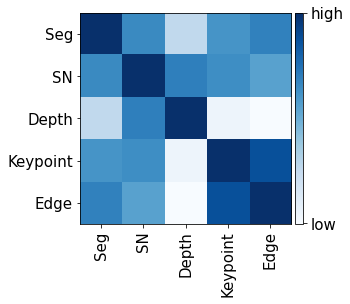

In [86]:
mpl.rc('image', cmap='Blues')

# plot
tickSize = 15
plt.figure(figsize=(4,4))
plt.xticks(fontsize=tickSize, rotation='vertical')
plt.yticks(fontsize=tickSize)

ax = plt.subplot()
im = ax.imshow(sim)
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(['Seg', 'SN', 'Depth', 'Keypoint', 'Edge'])
ax.set_yticklabels(['Seg', 'SN', 'Depth', 'Keypoint', 'Edge'])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)

cb = plt.colorbar(im, cax=cax,ticks=[1,0.61])
cb.ax.set_yticklabels(['high', 'low']) 
cb.ax.tick_params(labelsize=tickSize)
plt.show()

### Show Policy (for test)

In [9]:
from graphviz import Digraph

In [8]:
state = torch.load(folder+'NYUv2/' + 'alter_train_with_reg_001_20000iter.model')  # NYUv2
mtlmodel.load_state_dict(state['state_dict'], strict=False)

<All keys matched successfully>

In [89]:
dot = Digraph(comment='Policy')

# make nodes
layer_num = len(policy_list['segment_semantic'])
for i in range(layer_num):
    with dot.subgraph(name='cluster_L'+str(i),node_attr={'rank':'same'}) as c:
        c.attr(rankdir='LR')
        c.node('L'+str(i)+'B0', 'Shared')
        c.node('L'+str(i)+'B1', 'Specific')
        c.node('L'+str(i)+'B2', 'Skip')
        
# make edges
colors = {'segment_semantic': 'blue', 'depth_zbuffer': 'red'}
for task in tasks:
    for i in range(layer_num-1):
        prev = np.argmax(policy_list[task][i])
        nxt = np.argmax(policy_list[task][i+1])
        dot.edge('L'+str(i)+'B'+str(prev), 'L'+str(i+1)+'B'+str(nxt), color=colors[task])

In [90]:
dot.render('policy/NYUv2-Best.gv', view=True)  

'policy/CityScapes-Best.gv.pdf'

# Model Parmas

In [12]:
folder = '/work/lijunzhang_umass_edu/data/policymtl/checkpoint/'
# state = torch.load(folder+'Github-Models/CityScapes.model') 
# mtlmodel.load_state_dict(state, strict=False)
state = torch.load(folder+'Cityscapes/paper/no_pre/0-10-0.0005/' + 'post_train_30000iter.model')  
mtlmodel.load_state_dict(state['state_dict'], strict=False)

<All keys matched successfully>

In [7]:
state1 = torch.load(folder+'Cityscapes/paper/pre_re/0-10-0.0005/' + 'post_train_30000iter.model') 
state2 = torch.load(folder+'Cityscapes/paper/no_pre/0-10-0.0005/' + 'post_train_30000iter.model') 

In [9]:
for key in state1['state_dict']:
    if 'policy' in key:
        policy1 = state1['state_dict'][key]
        if np.array_equal(policy1.cpu().numpy(), np.array([0.,0.,0.])):
            pass
        else:
            policy2 = state2['state_dict'][key]
            print(key)
            print(policy1)
            print(policy2)

net.0.policy.segment_semantic
tensor([0., 0., 1.], device='cuda:0')
tensor([0., 1., 0.], device='cuda:0')
net.0.policy.depth_zbuffer
tensor([1., 0., 0.], device='cuda:0')
tensor([1., 0., 0.], device='cuda:0')
net.4.policy.segment_semantic
tensor([1., 0., 0.], device='cuda:0')
tensor([1., 0., 0.], device='cuda:0')
net.4.policy.depth_zbuffer
tensor([0., 0., 1.], device='cuda:0')
tensor([0., 0., 1.], device='cuda:0')
net.7.policy.segment_semantic
tensor([0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.], device='cuda:0')
net.7.policy.depth_zbuffer
tensor([1., 0., 0.], device='cuda:0')
tensor([1., 0., 0.], device='cuda:0')
net.11.policy.segment_semantic
tensor([0., 1., 0.], device='cuda:0')
tensor([0., 0., 1.], device='cuda:0')
net.11.policy.depth_zbuffer
tensor([0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.], device='cuda:0')
net.14.policy.segment_semantic
tensor([0., 1., 0.], device='cuda:0')
tensor([0., 1., 0.], device='cuda:0')
net.14.policy.depth_zbuffer
tensor([0., 1., 0.], device

In [13]:
singleParam = 0
mtlParam = 0
for node in mtlmodel.net:
    if node.taskSp and not node.assumeSp:
        shared = False
        
        params = node.basicOp.weight.data.nelement()
        if node.basicOp.bias is not None:
            params += node.basicOp.bias.data.nelement()
        singleParam += params
        
        for task in tasks:
            policy = node.policy[task].data.cpu().detach().numpy()
            if np.array_equal(policy, np.array([1.,0.,0.])):
                if not shared:
                    mtlParam += params
                    shared = True
            elif np.array_equal(policy, np.array([0.,1.,0.])):
                mtlParam += params
                
1 - mtlParam / (singleParam * len(tasks))

0.32163029969275403

In [14]:
mtlParam

28854656

In [12]:
singleParam

21267648

In [15]:
42.569*(1-0.32163029969275403)

28.877519772379156

# Inference Time

In [13]:
import time

from data.dataloader.cityscapes_dataloader import CityScapes
from data.metrics.pixel2pixel_loss import CityScapesCriterions
from data.metrics.pixel2pixel_metrics import CityScapesMetrics

In [29]:
dataroot = '/work/lijunzhang_umass_edu/data/policymtl/data/Cityscapes/'

valDataloaderDict = {}
for task in tasks:
    dataset = CityScapes(dataroot, 'test', task)
    valDataloaderDict[task] = DataLoader(dataset, 1, shuffle=False)

In [74]:
times = []
val_iter_dict = {}
for task in tasks:
    val_iter_dict[task] = iter(valDataloaderDict[task])
for i in range(50):
    temp = 0
    for task in tasks:
        x = next(val_iter_dict[task])['input'].cuda()
        start_time = time.time()
        # with torch.no_grad():
        output = mtlmodel(x, task=task, hard=True)
        temp += time.time()-start_time
    times.append(temp)

In [75]:
from statistics import mean
mean(times[0:])*1000

37.14889049530029

In [26]:
times

[0.06999659538269043,
 0.06348466873168945,
 0.05932426452636719,
 0.05931568145751953,
 0.059459686279296875,
 0.05993509292602539,
 0.05976247787475586,
 0.059697628021240234,
 0.059816598892211914,
 0.05985713005065918,
 0.059030771255493164,
 0.0597686767578125,
 0.06000065803527832,
 0.05977606773376465,
 0.059503793716430664,
 0.06101417541503906,
 0.058699607849121094,
 0.05982851982116699,
 0.05980348587036133,
 0.05955219268798828,
 0.05962181091308594,
 0.05957198143005371,
 0.0600736141204834,
 0.05986833572387695,
 0.05948901176452637,
 0.059577226638793945,
 0.059743404388427734,
 0.060059309005737305,
 0.05996894836425781,
 0.05944991111755371,
 0.059204816818237305,
 0.05974936485290527,
 0.05995893478393555,
 0.059630632400512695,
 0.059545040130615234,
 0.05965900421142578,
 0.0594785213470459,
 0.05977582931518555,
 0.05985307693481445,
 0.059745073318481445,
 0.05974149703979492,
 0.06208634376525879,
 0.059734344482421875,
 0.05978083610534668,
 0.05975818634033203,